In [4]:
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"


In [5]:
import pandas as pd

records = []  # uniprot_ac, kingdom, type_, sequence, label
with open("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.fasta", "r") as f:
    current_record = None
    for line in f:
        if line.startswith(">"):
            if current_record is not None:
                if current_record["sequence"] is not None and current_record["label"] is not None:
                    # Save the previous record before starting a new one
                    records.append(current_record)
                else:
                    # If the previous record is incomplete, skip it
                    print("Skipping incomplete record:", current_record)
            # Start a new record
            uniprot_ac, kingdom, type_ = line[1:].strip().split("|")
            current_record = {"uniprot_ac": uniprot_ac, "kingdom": kingdom, "type": type_, "sequence": None, "label": None}
        else:
            # Check if the line contains a sequence or a label
            if current_record["sequence"] is None:
                current_record["sequence"] = line.strip()
            elif current_record["label"] is None:
                current_record["label"] = line.strip()
            else:
                # If both sequence and label are already set, skip this line
                print("Skipping extra line in record:", current_record)
    # Save the last record if it's complete
    if current_record is not None:
        if current_record["sequence"] is not None and current_record["label"] is not None:
            records.append(current_record)
        else:
            print("Skipping incomplete record:", current_record)

"""
# Save the DataFrame to a CSV file
df_raw.to_csv("/Users/jonas/Desktop/Uni/PBL/data/complete_set_unpartitioned.csv", index=False)
"""
# Print the number of records
print(f"Total records: {len(records)}")
df_raw = pd.DataFrame(records)
df_raw.head()


Total records: 25693


,uniprot_ac,kingdom,type,sequence,label
0,Q8TF40,EUKARYA,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
1,Q1ENB6,EUKARYA,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
2,P36001,EUKARYA,NO_SP,MDDISGRQTLPRINRLLEHVGNPQDSLSILHIAGTNGKETVSKFLT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
3,P55317,EUKARYA,NO_SP,MLGTVKMEGHETSDWNSYYADTQEAYSSVPVSNMNSGLGSMNSMNT...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
4,P35583,EUKARYA,NO_SP,MLGAVKMEGHEPSDWSSYYAEPEGYSSVSNMNAGLGMNGMNTYMSM...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [6]:
df = df_raw[~df_raw["label"].str.contains("P")]
df["type"] = df["type"].replace("NO_SP", "0")
df["type"] = df["type"].replace("LIPO", "1")
df["type"] = df["type"].replace("SP", "1")
df["type"] = df["type"].replace("TAT", "1")
df["type"] = df["type"].replace("TATLIPO", "1")

df.describe()

/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_58584/2058272396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["type"] = df["type"].replace("NO_SP", "0")
/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_58584/2058272396.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["type"] = df["type"].replace("LIPO", "1")
/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_58584/2058272396.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,uniprot_ac,kingdom,type,sequence,label
count,25580,25580,25580,25580,25580
unique,25580,4,2,24367,1878
top,Q8TF40,EUKARYA,0,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
freq,1,20423,19036,41,16382


In [7]:
# perform oversampling 
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df[df["type"] == "0"]
df_minority = df[df["type"] != "0"]
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                  replace=True,     # sample with replacement
                                  n_samples=len(df_majority),    # to match majority class
                                  random_state=42) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
# Shuffle the dataset
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# total records after oversampling
print(f"Total records after oversampling: {len(df_upsampled)}")

# majority class distribution
print("Class distribution after oversampling:")
print(df_upsampled["type"].value_counts())

Total records after oversampling: 38072
Class distribution after oversampling:
type
1    19036
0    19036
Name: count, dtype: int64


In [8]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

df_encoded = df_upsampled.copy()
df_encoded["label"] = df_encoded["label"].apply(lambda x: [label_map[c] for c in x if c in label_map])
df_encoded = df_encoded[df_encoded["label"].map(len) > 0]  # Remove rows with empty label lists

# make random smaller dataset
#df_encoded = df_encoded.sample(frac=0.4, random_state=42)

sequences = df_encoded["sequence"].tolist()
types = df_encoded["type"].tolist()

df_encoded.describe()


,uniprot_ac,kingdom,type,sequence,label
count,38072,38072,38072,38072,38072
unique,25209,4,2,24079,1870
top,P01170,EUKARYA,1,MKLSRRSFMKANAVAAAAAAAGLSVPGVARAVVGQQEAIKWDKAPC...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
freq,10,25783,19036,126,16382


In [9]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = AutoModel.from_pretrained("Rostlab/prot_bert").to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, i

In [10]:
cls_embeddings = []

with torch.no_grad():
    for seq in sequences:
        inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True, max_length=512)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS token → shape: (1, 1024)
        cls_embeddings.append(cls_emb.squeeze().cpu().numpy())  # shape: (1024,)


In [11]:
import umap
import numpy as np

X = np.stack(cls_embeddings)  # shape: (num_sequences, 1024)
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_2d = reducer.fit_transform(X)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


['1' '1' '0' ... '0' '0' '0']
Unique types: ['0' '1']
Count for 0: 19036
Count for 1: 19036


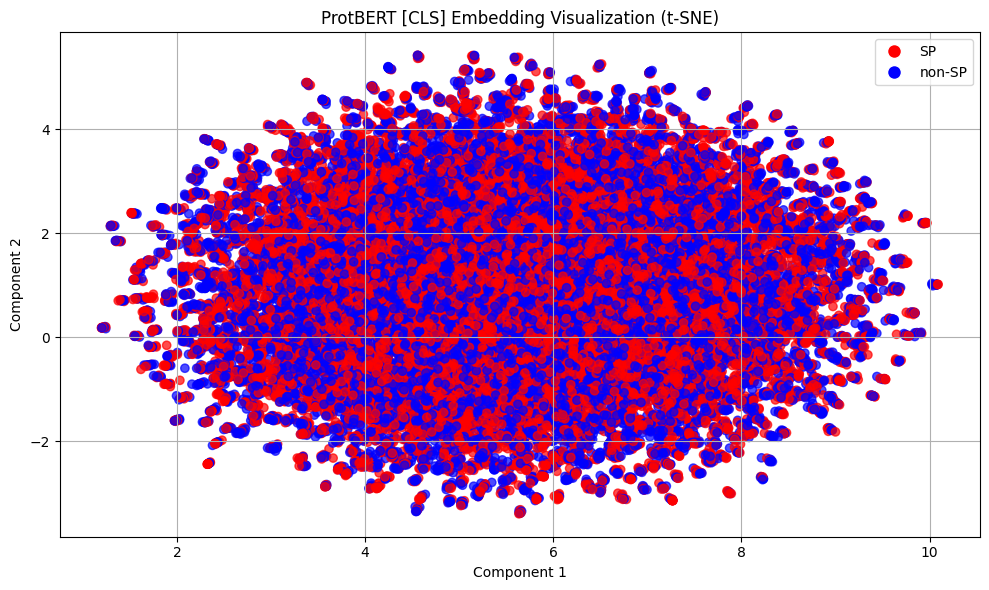

In [12]:
import matplotlib.pyplot as plt

import numpy as np
types_array = np.array(types) # converts ints to strings??
print(types_array)
print("Unique types:", np.unique(types_array))
print("Count for 0:", np.sum(types_array == "0"))
print("Count for 1:", np.sum(types_array == "1"))

plt.figure(figsize=(10, 6))
colors = ['red' if t == "1" else 'blue' for t in types]
labels = ['SP' if t == "1" else 'non-SP' for t in types]

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.7)

# Optional: Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='SP', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='non-SP', markerfacecolor='blue', markersize=10),
]
plt.legend(handles=legend_elements)

plt.title("ProtBERT [CLS] Embedding Visualization (t-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

